In [18]:
# ML
import re
import tqdm
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# DL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, BatchNormalization, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model, model_to_dot

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataSets/text_emotions.csv')
df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [3]:
df['length'] = df['text'].apply(len)

In [4]:
sentiment_counts = df['emotion'].value_counts()
sentiment_counts

emotion
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64

In [5]:
df.shape

(20000, 3)

In [6]:
df.head()

,text,emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


In [7]:
df = df.drop_duplicates()

In [8]:
df.isnull().sum()

text       0
emotion    0
length     0
dtype: int64

In [9]:
df.duplicated().sum()

0

<ipython-input-10-ff69e59ae497>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='emotion', data=df, palette='Set1')


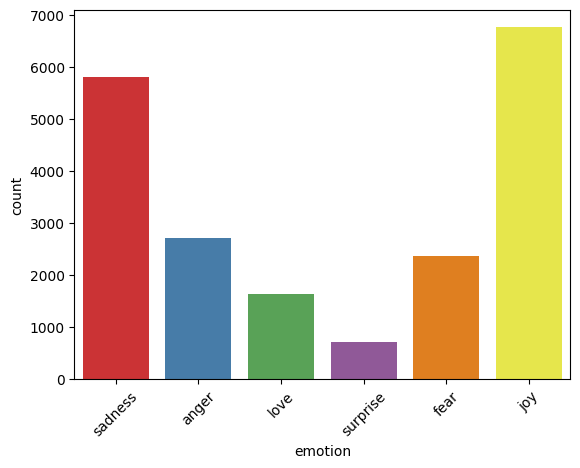

In [10]:
# EDA
sns.countplot(x='emotion', data=df, palette='Set1')
plt.xticks(rotation=45)
plt.show()

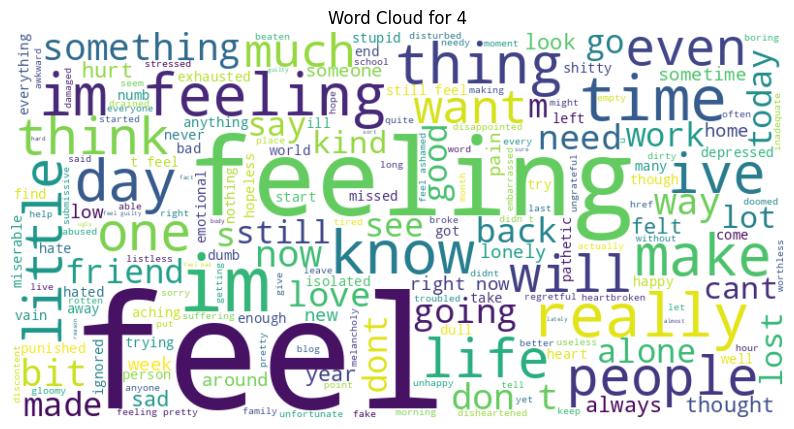

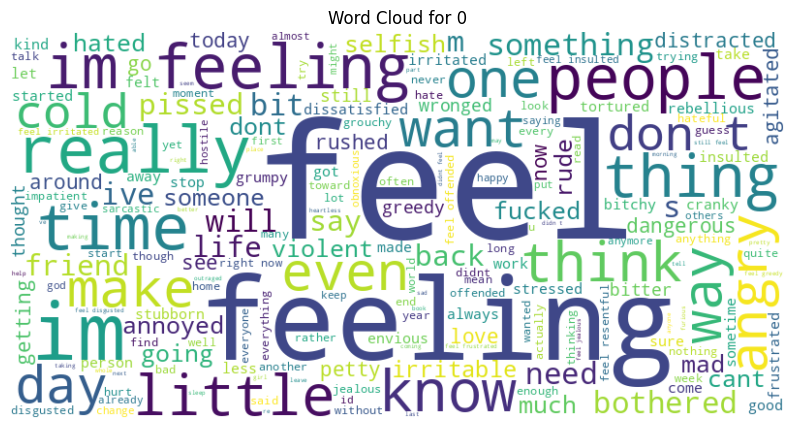

KeyboardInterrupt: 

In [33]:
def generate_word_cloud(emotion, text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 10), dpi=100)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {emotion}')

    filename = f'word_cloud_{emotion}.png'
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=100)

    plt.show()
    plt.close()


emotions = df['emotion'].unique()
for emotion in emotions:
    text = df[df['emotion'] == emotion]['text']
    generate_word_cloud(emotion, text)

In [34]:
# Data Preprocessing
lb = LabelEncoder()
df['emotion'] = lb.fit_transform(df['emotion'])
df.head()

,text,emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [12]:
ml_df = df.copy()
dl_df = df.copy()

In [35]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Machine Learning


In [36]:
def preprocess_text(text):
    stemmer = PorterStemmer()
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text)

    text = text.lower().split()
    words = [stemmer.stem(word) for word in text if word not in stopwords]

    return ' '.join(words)

In [37]:
tqdm.tqdm.pandas()
ml_df['processed_text'] = ml_df['text'].progress_apply(preprocess_text)

100%|██████████| 19999/19999 [00:06<00:00, 3215.68it/s]


In [15]:
ml_df.head(10)

,text,emotion,length,processed_text
0,i didnt feel humiliated,4,23,didnt feel humili
1,i can go from feeling so hopeless to so damned...,4,108,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,0,48,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,3,92,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,0,20,feel grouchi
5,ive been feeling a little burdened lately wasn...,4,65,ive feel littl burden late wasnt sure
6,ive been taking or milligrams or times recomme...,5,122,ive take milligram time recommend amount ive f...
7,i feel as confused about life as a teenager or...,1,73,feel confus life teenag jade year old man
8,i have been with petronas for years i feel tha...,2,98,petrona year feel petrona perform well made hu...
9,i feel romantic too,3,19,feel romant


In [89]:
class MultinomialNB:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        self._class_counts = np.zeros(n_classes, dtype=np.float64)
        self._feature_counts = np.zeros((n_classes, n_features), dtype=np.float64)
        self._class_log_priors = np.zeros(n_classes, dtype=np.float64)
        self._feature_log_probs = np.zeros((n_classes, n_features), dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._class_counts[idx] = X_c.shape[0]
            self._feature_counts[idx, :] = X_c.sum(axis=0) + self.alpha
            self._class_log_priors[idx] = np.log(self._class_counts[idx] / n_samples)

        self._feature_log_probs = np.log(self._feature_counts / self._feature_counts.sum(axis=1, keepdims=True))

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        log_posteriors = []

        for idx, c in enumerate(self._classes):
            log_prior = self._class_log_priors[idx]
            log_likelihood = np.sum(x * self._feature_log_probs[idx, :])
            log_posterior = log_prior + log_likelihood
            log_posteriors.append(log_posterior)

        return self._classes[np.argmax(log_posteriors)]

In [90]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [92]:
class SVC:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    self.weights -= self.learning_rate * (2 * self.lambda_param * self.weights)
                else:
                    self.weights -= self.learning_rate * (2 * self.lambda_param * self.weights - np.dot(x_i, y_[idx]))
                    self.bias -= self.learning_rate * y_[idx]

    def predict(self, X):
        linear_output = np.dot(X, self.weights) - self.bias
        return np.sign(linear_output)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(ml_df['processed_text'], ml_df['emotion'], test_size=0.2, random_state=42)

In [39]:
tf = TfidfVectorizer()
X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)

In [40]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [41]:
classifiers = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC()
}

for name, clf in classifiers.items():
    clf.fit(X_train_tf, y_train)
    predictions = clf.predict(X_test_tf)
    accuracy = accuracy_score(y_test, predictions)
    print(f"{name} accuracy: {accuracy}")

Multinomial Naive Bayes accuracy: 0.6765


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.84575
SVM accuracy: 0.82825


In [42]:
classifiers = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC()
}

for name, clf in classifiers.items():
    clf.fit(X_train_cv, y_train)
    predictions = clf.predict(X_test_cv)
    accuracy = accuracy_score(y_test, predictions)
    print(f"{name} accuracy: {accuracy}")

Multinomial Naive Bayes accuracy: 0.77775


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.858
SVM accuracy: 0.81075


In [43]:
# Logistic Regression with CountVectorizer
lg = LogisticRegression()
lg.fit(X_train_cv, y_train)
y_pred = lg.predict(X_test_cv)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
def predict_emotion(text):
  processed_text = preprocess_text(text)
  vectorized_text = cv.transform([processed_text])
  prediction = lg.predict(vectorized_text)[0]

  return lb.inverse_transform([prediction])[0]

In [46]:
pickle.dump(lg, open('lg.pkl', 'wb'))
pickle.dump(cv, open('vectorizer.pkl', 'wb'))
pickle.dump(lb, open('label_encoder.pkl', 'wb'))

# Deep Learning


In [26]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def preprocess_text_dl(text, vocab_size, max_length):
  stemmer = PorterStemmer()
  corpus = []
  for text in dl_df['text']:
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower().split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    corpus.append(' '.join(text))

  # One-hot encode and pad sequences for each document in the corpus
  one_hot_corpus = [one_hot(doc, vocab_size) for doc in corpus]
  embedded_corpus = pad_sequences(one_hot_corpus, maxlen=max_length, padding='post')

  return embedded_corpus

In [15]:
X_train = preprocess_text_dl(dl_df['text'], 15000, 200)
y_train = to_categorical(dl_df['emotion'])

In [16]:
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=15000, output_dim=32, input_length=200))
model_rnn.add(Dropout(0.2))
model_rnn.add(LSTM(32))
model_rnn.add(Dense(units=64, activation='sigmoid'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(units=6, activation='softmax'))
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_rnn.fit(X_train, y_train, epochs=25, batch_size=256, verbose=1, validation_split=0.2, callbacks=[callback])

Epoch 1/25
63/63 [==============================] - 19s 258ms/step - loss: 1.7384 - accuracy: 0.3102 - val_loss: 1.5728 - val_accuracy: 0.3498
Epoch 2/25
63/63 [==============================] - 24s 375ms/step - loss: 1.6088 - accuracy: 0.3200 - val_loss: 1.5691 - val_accuracy: 0.3498
Epoch 3/25
63/63 [==============================] - 19s 301ms/step - loss: 1.6031 - accuracy: 0.3201 - val_loss: 1.5695 - val_accuracy: 0.3498
Epoch 4/25
63/63 [==============================] - 20s 321ms/step - loss: 1.5943 - accuracy: 0.3179 - val_loss: 1.5697 - val_accuracy: 0.3498
Epoch 5/25
63/63 [==============================] - 23s 373ms/step - loss: 1.5897 - accuracy: 0.3205 - val_loss: 1.5691 - val_accuracy: 0.3498


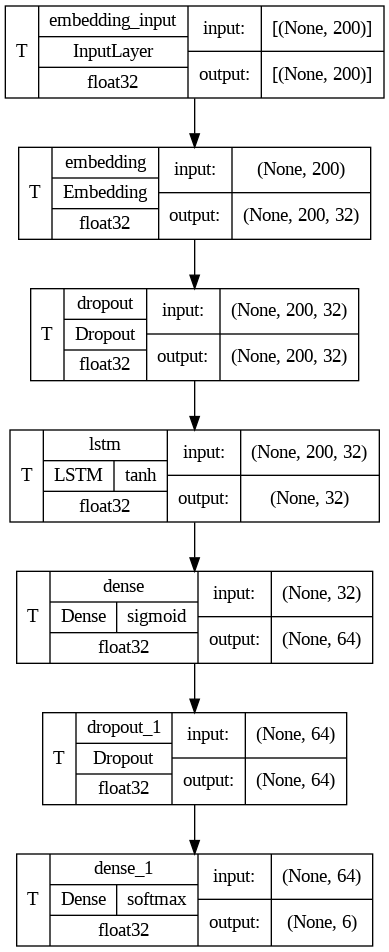

In [21]:
plot_model(model_rnn, to_file='rnn_model.png', show_shapes=True, show_dtype=True, show_layer_names=True, rankdir='TB', expand_nested=True,
          show_layer_activations=True, show_trainable=True)

In [20]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=15000, output_dim=32, input_length=200))
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(ReLU())
model_cnn.add(Dropout(0.2))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(6, activation='softmax'))
model_cnn.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn.fit(X_train, y_train, epochs=25, batch_size=256, verbose=1, validation_split=0.2)

Epoch 1/25
63/63 [==============================] - 14s 187ms/step - loss: 1.6363 - accuracy: 0.3382 - val_loss: 1.7491 - val_accuracy: 0.3282
Epoch 2/25
63/63 [==============================] - 12s 181ms/step - loss: 1.4718 - accuracy: 0.4253 - val_loss: 1.7285 - val_accuracy: 0.4227
Epoch 3/25
63/63 [==============================] - 12s 192ms/step - loss: 1.2462 - accuracy: 0.5382 - val_loss: 1.6828 - val_accuracy: 0.5692
Epoch 4/25
63/63 [==============================] - 13s 201ms/step - loss: 0.9423 - accuracy: 0.6748 - val_loss: 1.5780 - val_accuracy: 0.7303
Epoch 5/25
63/63 [==============================] - 14s 220ms/step - loss: 0.6864 - accuracy: 0.7660 - val_loss: 1.4089 - val_accuracy: 0.7947
Epoch 6/25
63/63 [==============================] - 10s 166ms/step - loss: 0.5132 - accuracy: 0.8276 - val_loss: 1.2013 - val_accuracy: 0.8342
Epoch 7/25
63/63 [==============================] - 13s 208ms/step - loss: 0.4028 - accuracy: 0.8659 - val_loss: 0.9536 - val_accuracy: 0.8522

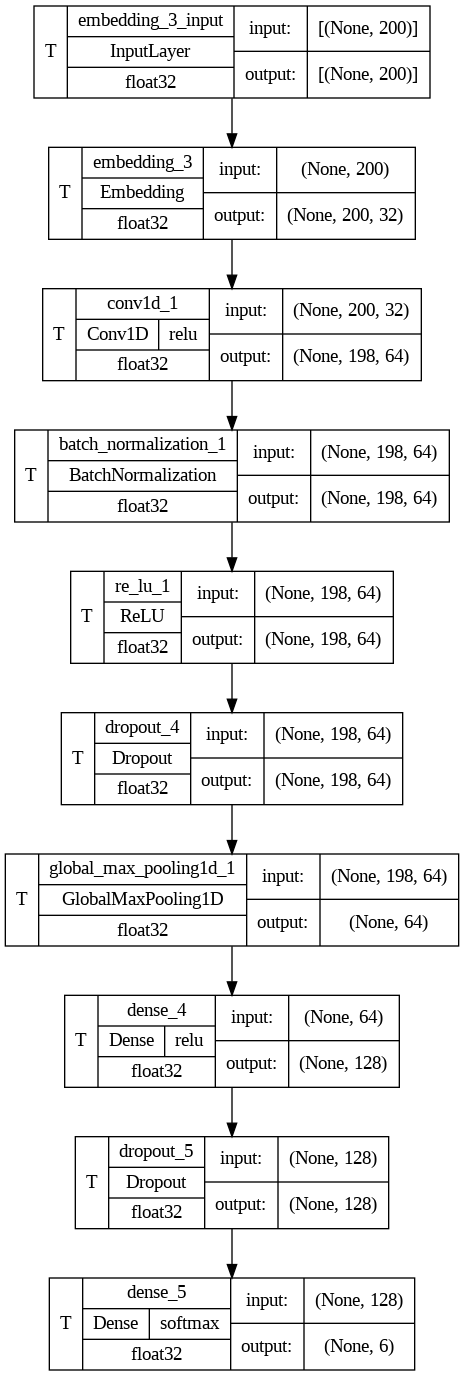

In [23]:
plot_model(model_cnn, to_file='cnn_model.png', show_shapes=True, show_dtype=True, show_layer_names=True, rankdir='TB', expand_nested=True,
          show_layer_activations=True, show_trainable=True)